In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class bandit_env:

    def __init__(self,k,mu):

        self.arms=np.arange(k)
        self.mu=mu

        self.variance=1

    def pull_arm(self,arm):

        if arm not in self.arms:
            return
        reward=np.random.normal(self.mu[arm],1)

        return  reward
    

    def greedy(self,m,rounds):
        regret=np.zeros((rounds,1))
        q_a=np.zeros((self.arms.shape[0],1))
        rewards=np.zeros((rounds,1))
        for t in range(m):
            for arm in self.arms:
                regret[(t*self.arms.shape[0])+arm]+=arm
                r=self.pull_arm(arm)
                q_a[arm]+=r
                rewards[(t*self.arms.shape[0])+arm]+=r

        counts=np.ones((self.arms.shape[0],1))*m
        q_a/=m
        for t in range((m*self.arms.shape[0])+1,rounds):
            max_arm=np.argmax(q_a)
            regret[t]+=max_arm
            r=self.pull_arm(max_arm)
            q_a[max_arm]=(counts[max_arm]*q_a[max_arm])+r
            counts[max_arm]+=1
            rewards[t]+=r
            q_a[max_arm]=q_a[max_arm]/(counts[max_arm])
            
        regret-=self.arms[-1] 

        return q_a,counts,rewards,-regret
    
    def epsilon_greedy(self,m,rounds,epsilon):

        regret=np.zeros((rounds,1))

        q_a=np.zeros((self.arms.shape[0],1))
        rewards=np.zeros((rounds,1))
        for t in range(m):
            for arm in self.arms:
                r=self.pull_arm(arm)
                regret[(t*self.arms.shape[0])+arm]+=arm
                q_a[arm]+=r
                rewards[(t*self.arms.shape[0])+arm]+=r

        counts=np.ones((self.arms.shape[0],1))*m
        q_a/=m
        for t in range((m*self.arms.shape[0])+1,rounds):

            weights=[epsilon/self.arms.shape[0]]*self.arms.shape[0]
            max_arm=np.argmax(q_a)
            weights[max_arm]+=(1-epsilon)
            max_arm=random.choices(self.arms,weights)[0]

            r=self.pull_arm(max_arm)
            regret[t]+=max_arm

            q_a[max_arm]=(counts[max_arm]*q_a[max_arm])+r
            counts[max_arm]+=1
            rewards[t]+=r
            q_a[max_arm]=q_a[max_arm]/(counts[max_arm])


        regret-=self.arms[-1] 

        return q_a,counts,rewards,-regret
    
    def epsilon_greedy_decay(self,m,rounds,epsilon,decay):

        assert decay<1, "Decay coeffecient must lie in (0,1)"
        q_a=np.zeros((self.arms.shape[0],1))
        regret=np.zeros((rounds,1))
        rewards=np.zeros((rounds,1))
        for t in range(m):
            for arm in self.arms:
                regret[(t*self.arms.shape[0])+arm]+=arm
                r=self.pull_arm(arm)
                q_a[arm]+=r
                rewards[(t*self.arms.shape[0])+arm]+=r

                

        counts=np.ones((self.arms.shape[0],1))*m
        q_a/=m
        for t in range((m*self.arms.shape[0])+1,rounds):
            weights=[epsilon/self.arms.shape[0]]*self.arms.shape[0]
            max_arm=np.argmax(q_a)
            weights[max_arm]+=(1-epsilon)
            max_arm=random.choices(self.arms,weights)[0]
            r=self.pull_arm(max_arm)
            regret[t]+=max_arm
            q_a[max_arm]=(counts[max_arm]*q_a[max_arm])+r
            counts[max_arm]+=1
            q_a[max_arm]=q_a[max_arm]/(counts[max_arm])
            rewards[t]+=r
            epsilon*=decay
        
        regret-=self.arms[-1]    
            
        return q_a,counts,rewards,-regret

    def UCB(self,rounds):

        regret=np.zeros((rounds,1))
        arms=self.arms.shape[0]
        reward=np.zeros((rounds,1))
        counts=np.ones((arms,1))
       
        q_s=np.zeros((arms,1))
        for i in range(arms):
            regret[i]+=i
            r=self.pull_arm(i)
            reward[i]+=r
            q_s[i]+=r
        
        t=arms
        for _ in range(rounds-arms):
            max_arm=None
            val=None
            for i in range(arms):
                if i==0:
                    max_arm=0
                    val=q_s[i]+np.sqrt((2*np.log(t))/(counts[i]))

                    continue

                temp=q_s[i]+np.sqrt((2*np.log(t))/(counts[i]))
                
                if temp>val:
                    val=temp
                    max_arm=i
            
            r=self.pull_arm(max_arm)
            regret[t]+=max_arm
            q_s[max_arm]=(q_s[max_arm]*counts[max_arm])+r
            counts[max_arm]+=1
            q_s[max_arm]/=counts[max_arm]
            reward[t]+=r
            t+=1
            
        regret-=self.arms[-1] 

        return q_s,counts,reward,-regret



In [3]:
#Initialize 10 arms
env=bandit_env(10,np.arange(10))

In [4]:
def plots(env):
    greedy_q=np.zeros((10,1))
    greedy_c=np.zeros((10,1))
    gr=np.zeros((1000,1))
    regret_g=np.zeros((1000,1))

    for rounds in range(100):
        g,c,r,rg=env.greedy(10,1000)
        greedy_q+=g
        greedy_c+=c
        gr+=r
        regret_g+=rg

    greedy_q/=100
    greedy_c/=100
    gr/=100
    regret_g/=100
        

    e_greedy_q=np.zeros((10,1))
    e_greedy_c=np.zeros((10,1))
    egr=np.zeros((1000,1))
    regret_eg=np.zeros((1000,1))

    for rounds in range(100):
        g,c,r,rg=env.epsilon_greedy(10,1000,0.01)
        e_greedy_q+=g
        e_greedy_c+=c
        egr+=r
        regret_eg+=rg

    e_greedy_q/=100
    e_greedy_c/=100
    egr/=100
    regret_eg/=100

    e_greedy_q1=np.zeros((10,1))
    e_greedy_c1=np.zeros((10,1))
    egr1=np.zeros((1000,1))
    regret_eg1=np.zeros((1000,1))

    for rounds in range(100):
        g,c,r,rg=env.epsilon_greedy(10,1000,0.1)
        e_greedy_q1+=g
        e_greedy_c1+=c
        egr1+=r
        regret_eg1+=rg


    e_greedy_q1/=100
    e_greedy_c1/=100
    egr1/=100
    regret_eg1/=100

    ed_q=np.zeros((10,1))
    ed_c=np.zeros((10,1))
    ed_r=np.zeros((1000,1))
    ed_regret=np.zeros((1000,1))

    for round in range(100):
        g,c,r,rg=env.epsilon_greedy_decay(10,1000,0.01,0.98)
        ed_q+=g
        ed_c+=c
        ed_r+=r
        ed_regret+=rg

    ed_r=ed_r/100
    ed_q=ed_q/100
    ed_c=ed_c/100
    ed_regret/=100

    ed_q1=np.zeros((10,1))
    ed_c1=np.zeros((10,1))
    ed_r1=np.zeros((1000,1))
    ed_regret1=np.zeros((1000,1))

    for round in range(100):
        g,c,r,rg=env.epsilon_greedy_decay(10,1000,0.1,0.98)
        ed_q1+=g
        ed_c1+=c
        ed_r1+=r
        ed_regret1+=rg

    ed_q1/=100
    ed_c1/=100
    ed_r1/=100
    ed_regret1/=100

    ucb_q=np.zeros((10,1))
    ucb_c=np.zeros((10,1))
    ucb_r=np.zeros((1000,1))
    ucb_regret=np.zeros((1000,1))

    for rounds in range(100):   
        q,c,r,rg=env.UCB(1000)
        ucb_q+=q
        ucb_c+=c
        ucb_r+=r
        ucb_regret+=rg

    ucb_q/=100
    ucb_c/=100
    ucb_r/=100
    ucb_regret/=100
    
    print("""Plots for Avg-reward per round\n""")
    plt.subplot(2,1,1)
    plt.plot(range(1000),gr,color='r',label='Greedy')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),egr,color='b',label='$\\epsilon -greedy$ \n$\\epsilon =0.01$')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.plot(range(1000),egr1,color='orange',label='$\\epsilon -greedy$ \n$\\epsilon =0.1$')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),ed_r,color='y',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.plot(range(1000),ed_r1,color='black',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),ucb_r,color='deeppink',label='UCB')
    plt.ylabel('Avg-reward')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('Plots for average number of times arm was pulled \n')
    plt.subplot(2,1,1)
    plt.bar(range(10),greedy_c.flatten(),color='r',label='Greedy')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.bar(range(10),e_greedy_c.flatten(),color='b',label='$\\epsilon -greedy$ \n$\\epsilon =0.01$')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.bar(range(10),e_greedy_c1.flatten(),color='orange',label='$\\epsilon -greedy$ \n$\\epsilon =0.1$')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.bar(range(10),ed_c.flatten(),color='y',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.bar(range(10),ed_c1.flatten(),color='black',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.bar(range(10),ucb_c.flatten(),color='deeppink',label='UCB')
    plt.ylabel('Avg-Count')
    plt.xlabel('Arm')
    plt.legend()
    plt.grid()
    plt.show()

    print("""Plots for Avg-regret per round\n""")
    plt.subplot(2,1,1)
    plt.plot(range(1000),regret_g,color='r',label='Greedy')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),regret_eg,color='b',label='$\\epsilon -greedy$ \n$\\epsilon =0.01$')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.plot(range(1000),regret_eg1,color='orange',label='$\\epsilon -greedy$ \n$\\epsilon =0.1$')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),ed_regret,color='y',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(2,1,1)
    plt.plot(range(1000),ed_regret1,color='black',label='$\\epsilon -greedy$ \n$\\epsilon =0.01,decay=0.98$')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(range(1000),ucb_regret,color='deeppink',label='UCB')
    plt.ylabel('Avg-regret')
    plt.xlabel('Round')
    plt.legend()
    plt.grid()
    plt.show()

Plots for Avg-reward per round



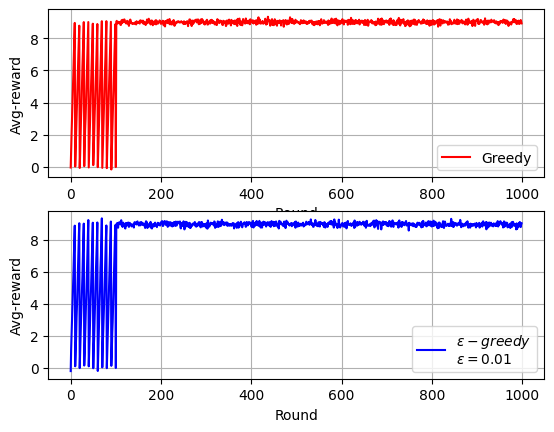

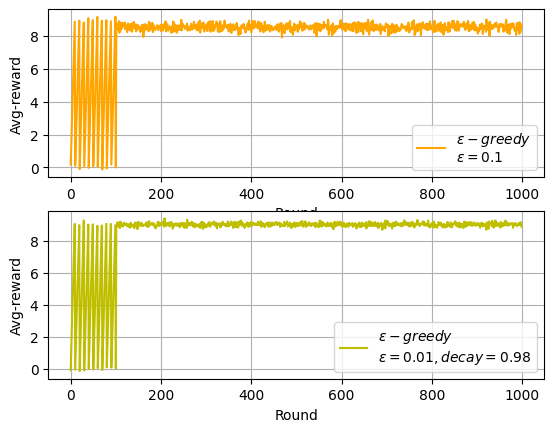

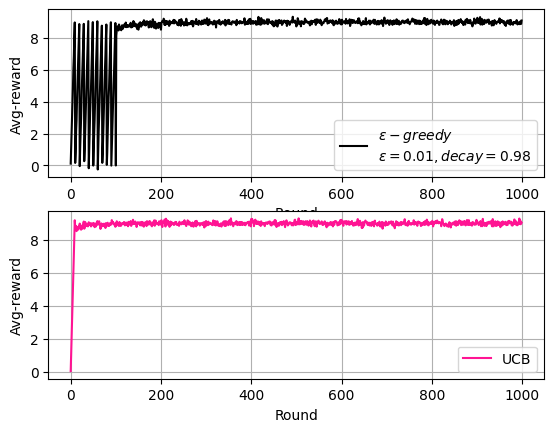

Plots for average number of times arm was pulled 



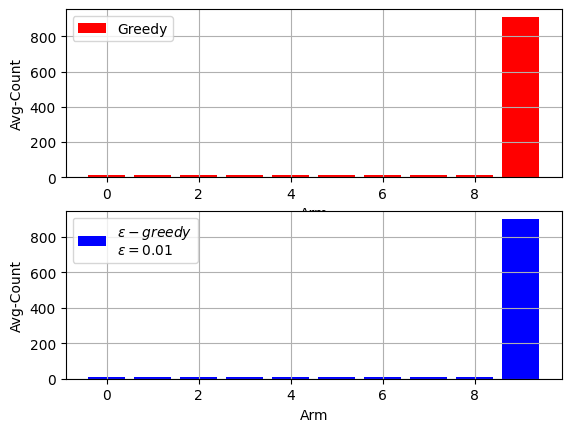

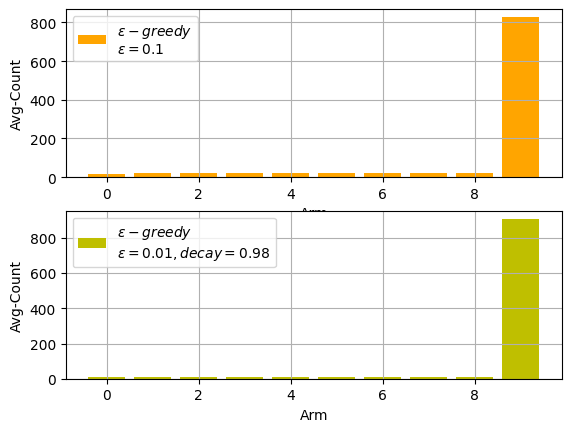

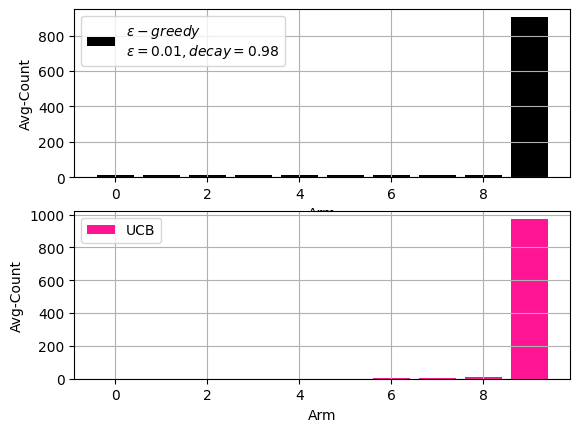

Plots for Avg-regret per round



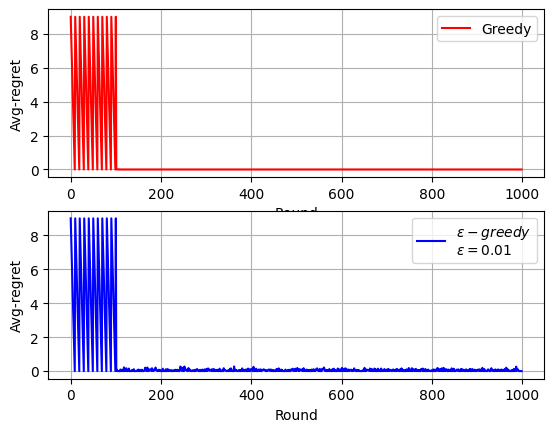

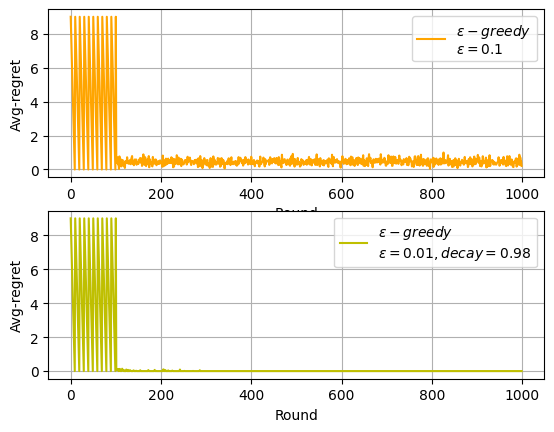

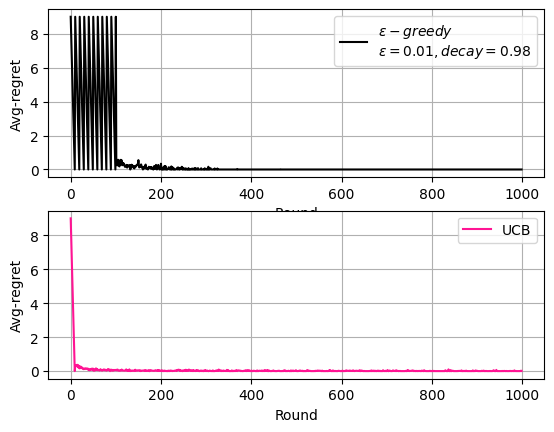

In [5]:
plots(env)

Clearly UCB algorithm is the best among the others since it starts getting higher rewards faster compared to others(from the graphs) and the regret decreases faster as compared to others.


In [6]:
means=[]
for i in range(10):
    means.append(np.random.normal(0,1))

means=np.array(means)
env=bandit_env(10,means)

Plots for Avg-reward per round



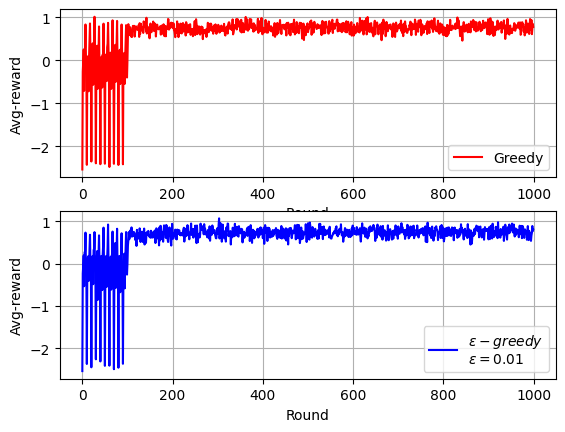

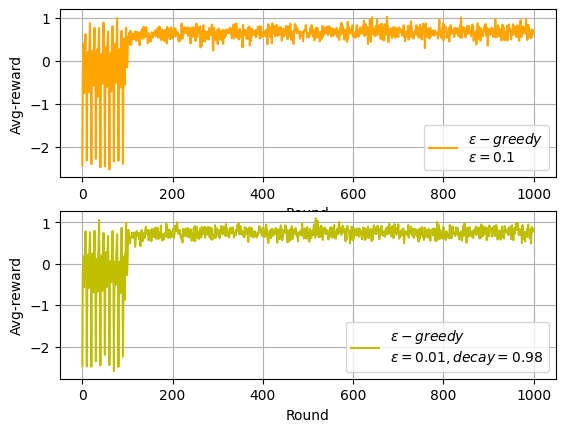

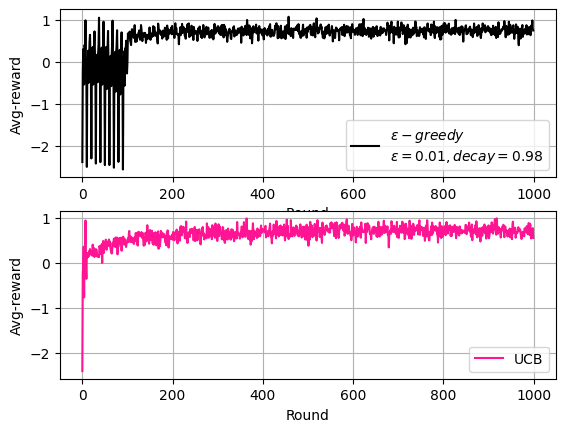

Plots for average number of times arm was pulled 



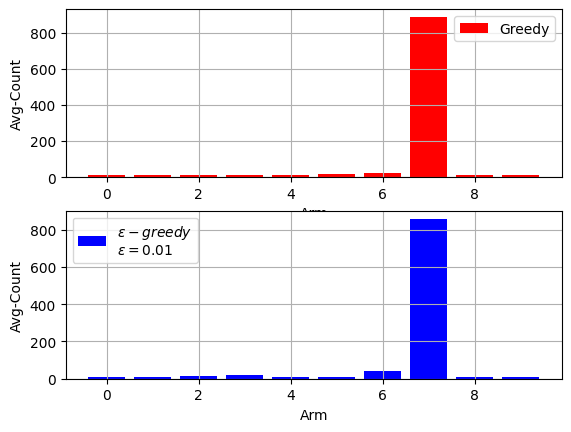

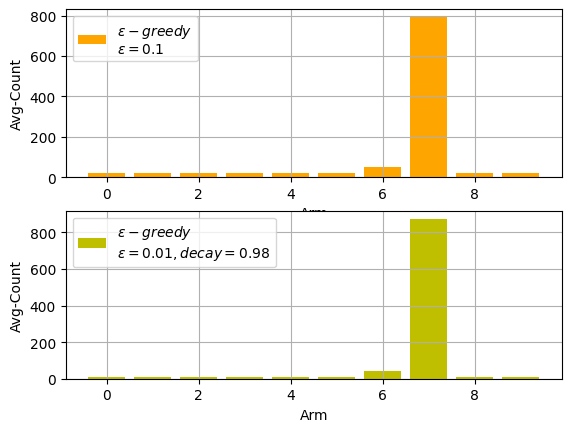

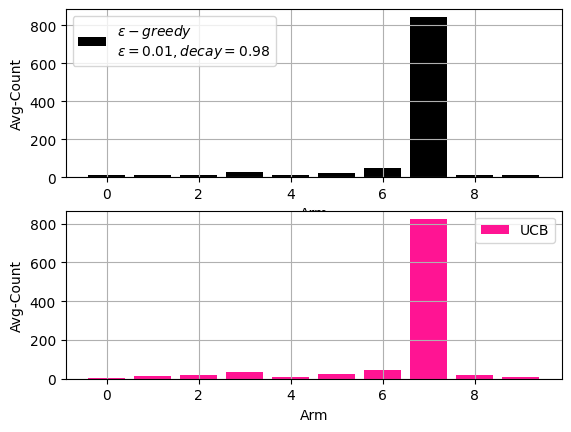

Plots for Avg-regret per round



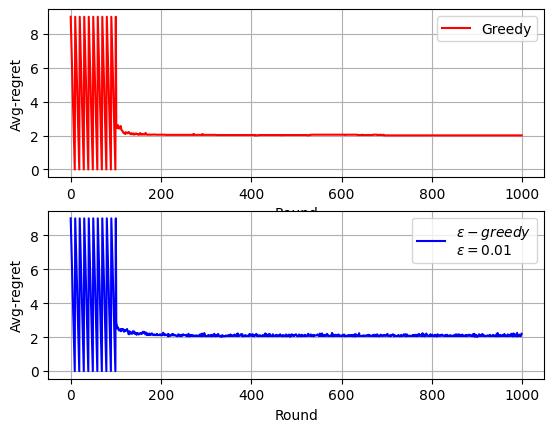

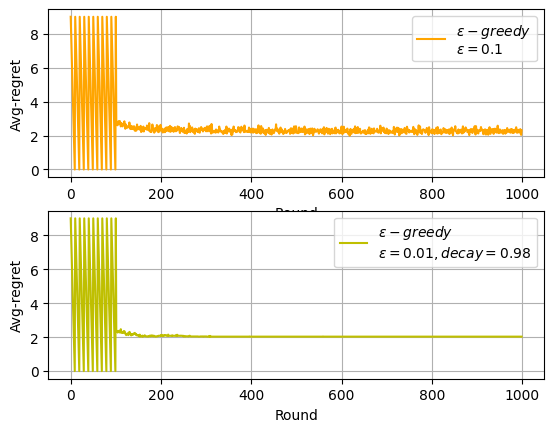

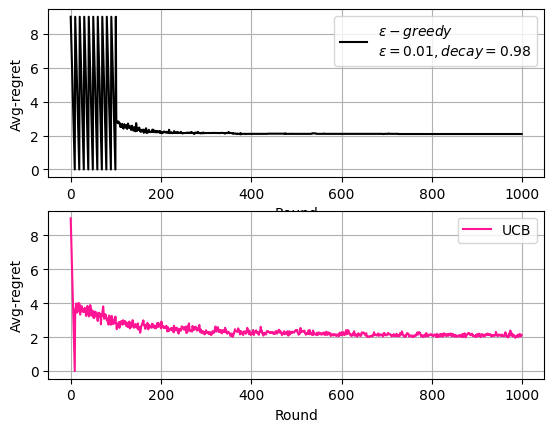

In [7]:
plots(env)